<a href="https://colab.research.google.com/github/lhartwig22/419-420_Algorithm/blob/main/COPD_PredictiveModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction & Guidance for COPD Diagnosis
**Author:** lhartwig@hawk.iit.edu <br>
**Date created:** 11/26/2022 <br>
**Last modified:** 01/17/2023 <br>
**Description:** Binary classification of structured data including numerical and categorical features to predict the risk of COPD. Keras preprocessing layers are used to normalize the numerical features and vectorize the categorical ones.



## Prediction by structured data classification

### Setup

In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

### Prepare the data

Download the data and load it into a Pandas dataframe:

In [35]:
file_url = "https://github.com/lhartwig22/419-420_Algorithm/raw/main/Compressed%20COPD%20Dataset.csv"
dataframe = pd.read_csv(file_url, encoding='latin-1')

A preview of the first few samples:

In [36]:
dataframe.head()

,AGE,gender,PackHistory,smoking,FEV1,FVC,FEV1%,Diabetes,muscular,hypertension,AtrialFib,IHD,copd
0,77,1,60.0,1,1.21,2.40,0.504167,1,0,0,1,0,1
1,79,0,50.0,1,1.09,1.64,0.660000,1,0,0,1,1,1
2,80,0,11.0,1,1.52,2.30,0.660870,1,0,0,1,0,1
3,56,1,60.0,1,0.47,1.14,0.410000,0,0,1,1,0,1
4,65,1,68.0,1,1.07,2.91,0.370000,0,1,1,0,0,1


Our dataset includes 100 samples (50 positve and 50 negative) with 13 columns per sample (12 features, plus COPD label)

In [37]:
dataframe.shape

(100, 13)

Split the data into a training and validation set:

In [38]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 80 samples for training and 20 for validation


Let's generate `tf.data.Dataset` objects for each dataframe:

In [39]:

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("copd")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Each `Dataset` yields a tuple `(input, copd)` where `input` is a dictionary of features
and `copd` is the value `0` or `1`:

In [40]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("COPD Stage:", y)

Input: {'AGE': <tf.Tensor: shape=(), dtype=int64, numpy=72>, 'gender': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'PackHistory': <tf.Tensor: shape=(), dtype=float64, numpy=50.0>, 'smoking': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'FEV1': <tf.Tensor: shape=(), dtype=float64, numpy=2.13>, 'FVC': <tf.Tensor: shape=(), dtype=float64, numpy=4.38>, 'FEV1%': <tf.Tensor: shape=(), dtype=float64, numpy=0.49>, 'Diabetes': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'muscular': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'hypertension': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'AtrialFib': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'IHD': <tf.Tensor: shape=(), dtype=int64, numpy=0>}
COPD Stage: tf.Tensor(1, shape=(), dtype=int64)


Batch the dataset:

In [41]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

### Feature preprocessing with Keras layers

The following categorical features are encoded as integers using `IntegerLookup()`:

- `gender`
- `smoking`
- `diabetes`
- `muscular`
- `hypertension`
- `atrialfib`
- `IHD`

The following continuous numerical features using a `Normalization()` layer:

- `age`
- `packhistory`
- `FEV1`
- `FVC`
- `FEV1%`

Below, we define 2 utility functions to do the operations:

- `encode_numerical_feature` to apply featurewise normalization to numerical features.
- `encode_integer_categorical_feature` to one-hot encode integer categorical features.

In [42]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


### Build a model

Next, we can create our end-to-end model:

In [43]:
# Categorical features encoded as integers
gender = keras.Input(shape=(1,), name="gender", dtype="int64")
smoking = keras.Input(shape=(1,), name="smoking", dtype="int64")
diabetes = keras.Input(shape=(1,), name="Diabetes", dtype="int64")
muscular = keras.Input(shape=(1,), name="muscular", dtype="int64")
hypertension = keras.Input(shape=(1,), name="hypertension", dtype="int64")
atrialFib = keras.Input(shape=(1,), name="AtrialFib", dtype="int64")
IHD = keras.Input(shape=(1,), name="IHD", dtype="int64")

# Numerical features
age = keras.Input(shape=(1,), name="AGE")
packHistory = keras.Input(shape=(1,), name="PackHistory")
FEV1 = keras.Input(shape=(1,), name="FEV1")
FVC = keras.Input(shape=(1,), name="FVC")
FEV1p = keras.Input(shape=(1,), name="FEV1%")

all_inputs = [
    gender,
    age,
    packHistory,
    smoking,
    FEV1,
    FVC,
    FEV1p,
    diabetes,
    muscular,
    hypertension,
    atrialFib,
    IHD,
]

# Integer categorical features
gender_encoded = encode_categorical_feature(gender, "gender", train_ds, False)
smoking_endcoded = encode_categorical_feature(smoking, "smoking", train_ds, False)
diabetes_encoded = encode_categorical_feature(diabetes, "Diabetes", train_ds, False)
muscular_encoded = encode_categorical_feature(muscular, "muscular", train_ds, False)
hypertension_encoded = encode_categorical_feature(hypertension, "hypertension", train_ds, False)
atrialFib_encoded = encode_categorical_feature(atrialFib, "AtrialFib", train_ds, False)
IHD_encoded = encode_categorical_feature(IHD, "IHD", train_ds, False)

# Numerical features
age_encoded = encode_numerical_feature(age, "AGE", train_ds)
packHistory_encoded = encode_numerical_feature(packHistory, "PackHistory", train_ds)
FEV1_encoded = encode_numerical_feature(FEV1p, "FEV1", train_ds)
FVC_encoded = encode_numerical_feature(FEV1p, "FVC", train_ds)
FEV1p_encoded = encode_numerical_feature(FEV1p, "FEV1%", train_ds)

all_features = layers.concatenate(
    [
        gender_encoded,
        age_encoded,
        packHistory_encoded,
        smoking_endcoded,
        FEV1_encoded,
        FVC_encoded,
        FEV1p_encoded,
        diabetes_encoded,
        muscular_encoded,
        hypertension_encoded,
        atrialFib_encoded,
        IHD_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

Visualize connectivity graph:

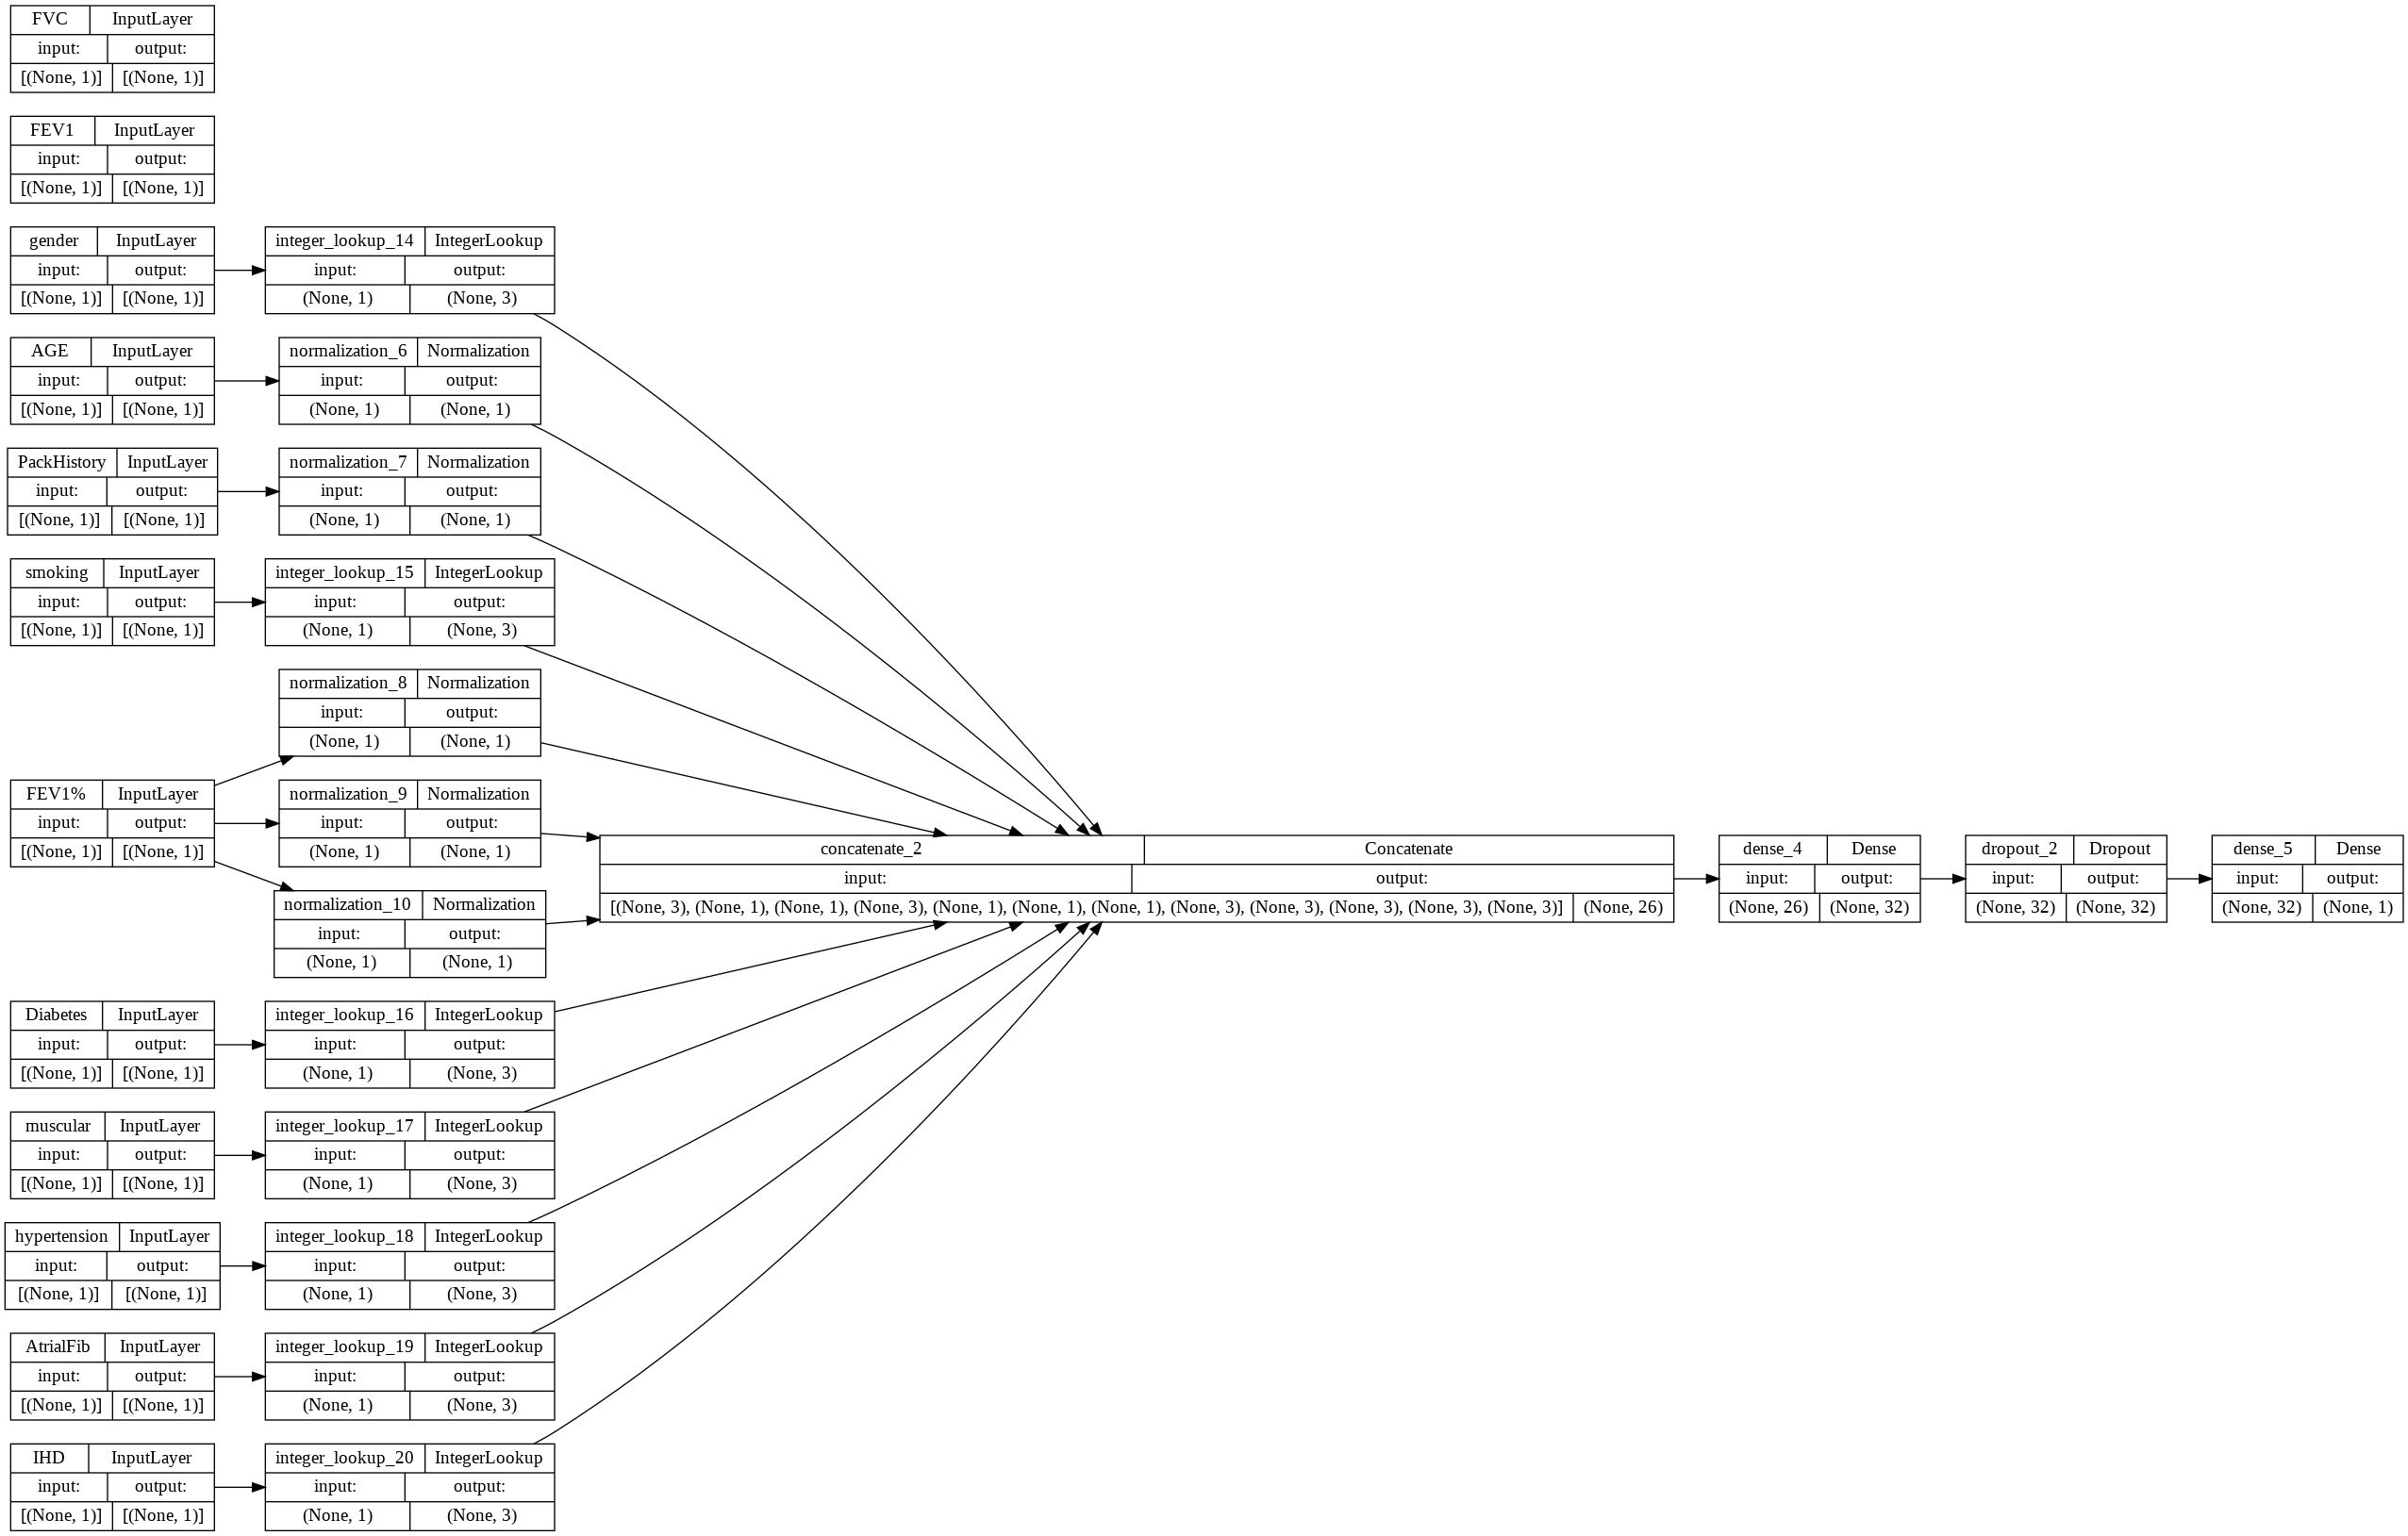

In [44]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the model

In [45]:
model.fit(train_ds, epochs=33, validation_data=val_ds)
#epochs=33 used since (columns=11)*3=33

Epoch 1/33
3/3 [==============================] - 1s 187ms/step - loss: 0.8899 - accuracy: 0.4875 - val_loss: 0.8013 - val_accuracy: 0.5000
Epoch 2/33
3/3 [==============================] - 0s 9ms/step - loss: 0.8476 - accuracy: 0.5000 - val_loss: 0.7722 - val_accuracy: 0.5000
Epoch 3/33
3/3 [==============================] - 0s 9ms/step - loss: 0.7428 - accuracy: 0.5375 - val_loss: 0.7437 - val_accuracy: 0.5000
Epoch 4/33
3/3 [==============================] - 0s 10ms/step - loss: 0.7960 - accuracy: 0.5750 - val_loss: 0.7157 - val_accuracy: 0.5000
Epoch 5/33
3/3 [==============================] - 0s 9ms/step - loss: 0.7405 - accuracy: 0.5500 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 6/33
3/3 [==============================] - 0s 13ms/step - loss: 0.7319 - accuracy: 0.5625 - val_loss: 0.6611 - val_accuracy: 0.5000
Epoch 7/33
3/3 [==============================] - 0s 9ms/step - loss: 0.6596 - accuracy: 0.6250 - val_loss: 0.6354 - val_accuracy: 0.5500
Epoch 8/33
3/3 [==============

## Prediction for a new sample

Call `model.predict()` to get a prediction for a new sample. <br>
There are just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [46]:
sample = {
    "AGE": 52,
    "gender": 1,
    "PackHistory": 40,
    "smoking": 1,
    "FEV1": 2.93,
    "FVC": 3.63,
    "FEV1%": 0.81,
    "Diabetes": 0,
    "muscular": 0,
    "hypertension": 0,
    "AtrialFib": 0,
    "IHD": 0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having COPD, as evaluated by our model." % (100 * predictions[0][0],)
)

1/1 [==============================] - 0s 268ms/step
This particular patient had a 50.1 percent probability of having COPD, as evaluated by our model.


## Guidance for new sample

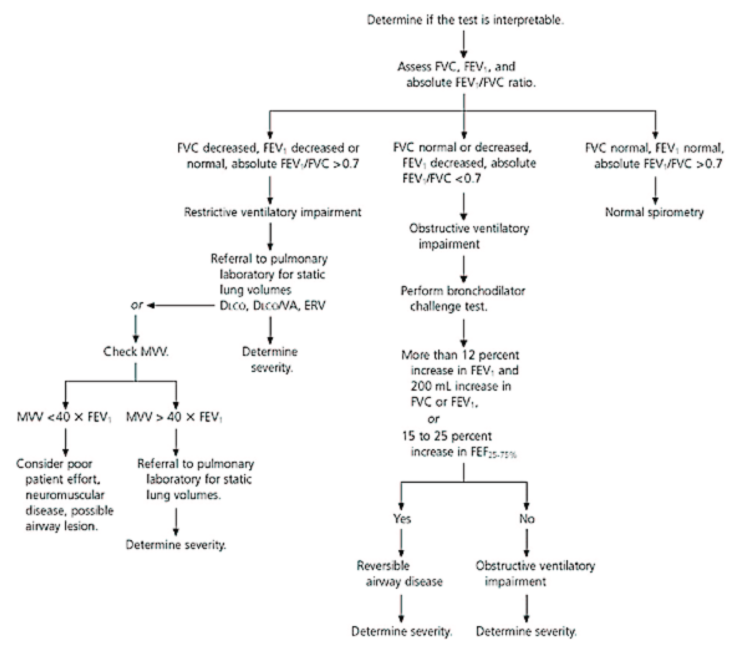